# Polynomial chaos graphs

In this basic example we are going to create some graphs useful after the launch of a polynomial chaos algorithm such as:

- Graph 1: the drawings of some members of the 1D polynomial family,
- Graph 2: the cloud of points making the comparison between the model values and the meta model ones: if the adequation is perfect, points must be on the first diagonal.

In [36]:
from __future__ import print_function
import openturns as ot

In [37]:
def drawFamily(factory, degreeMax=5):
    # Load all the valid colors
    colorList = ot.Drawable.BuildDefaultPalette(degreeMax)

    # Create a fine title
    titleJacobi = factory.__class__.__name__.replace('Factory', '') + " polynomials"

    # Create an empty graph which will be fullfilled
    # with curves
    graphJacobi = ot.Graph(titleJacobi, "z", "polynomial values", True, "topright")

    # Fix the number of points for the graph
    pointNumber = 101

    # Bounds of the graph
    xMinJacobi = -1.0
    xMaxJacobi = 1.0

    # Get the curves
    for i in range(degreeMax):
        graphJacobi_temp = factory.build(i).draw(
            xMinJacobi, xMaxJacobi, pointNumber)
        graphJacobi_temp_draw = graphJacobi_temp.getDrawable(0)
        graphJacobi_temp_draw.setLegend("degree " + str(i))
        graphJacobi_temp_draw.setColor(colorList[i])
        graphJacobi.add(graphJacobi_temp_draw)
    return graphJacobi

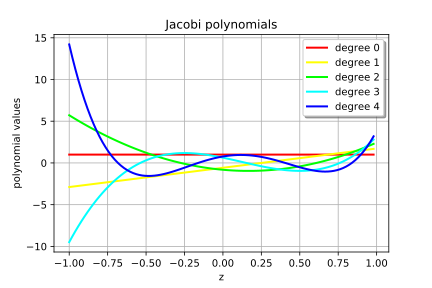

In [38]:
#################################################
# GRAPH 1 : drawings of the 5-th first members of
# the Jacobi family
#################################################

# Create the Jacobi polynomials family using the default Jacobi.ANALYSIS
# parameter set
alpha = 0.5
beta = 1.5
jacobiFamily = ot.JacobiFactory(alpha, beta)
drawFamily(jacobiFamily)

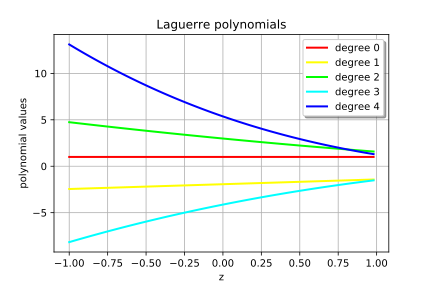

In [39]:
laguerreFamily = ot.LaguerreFactory(2.75, 1)
drawFamily(laguerreFamily)

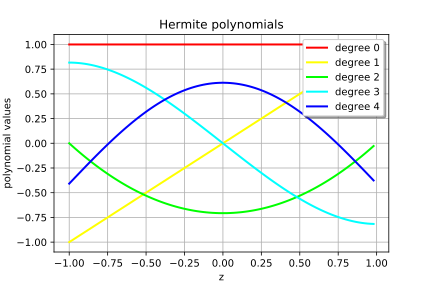

In [40]:
drawFamily(ot.HermiteFactory())

In [41]:
# Create a function R^n --> R^p
# For example R^4 --> R
myModel = ot.SymbolicFunction(['x1', 'x2', 'x3', 'x4'], ['1+x1*x2 + 2*x3^2+x4^4'])

# Create a distribution of dimension n
# for example n=3 with indpendent components
Xdist = ot.ComposedDistribution(
    [ot.Normal(), ot.Uniform(), ot.Gamma(2.75, 1.0), ot.Beta(2.5, 3.5, -1.0, 2.0)])

#############################################################
# STEP 1 : Construction of the multivariate orthonormal basis
#############################################################

# Dimension of the input random vector
dim = 4

# Create the univariate polynomial family collection
polyColl = ot.PolynomialFamilyCollection(dim)
# For information, with the Krawtchouk and Charlier families :
polyColl[0] = ot.KrawtchoukFactory()
polyColl[1] = ot.CharlierFactory()
# which regroups the polynomial families for each direction
polyColl = ot.PolynomialFamilyCollection(dim)
polyColl[0] = ot.HermiteFactory()
polyColl[1] = ot.LegendreFactory()
polyColl[2] = ot.LaguerreFactory(2.75, 1)
# Parameter for the Jacobi factory : 'Probabilty' encoded with 1
polyColl[3] = ot.JacobiFactory(2.5, 3.5, 1)


# Create the enumeration function
# LinearEnumerateFunction
enumerateFunction = ot.LinearEnumerateFunction(dim)
# HyperbolicAnisotropicEnumerateFunction
q = 0.4
enumerateFunction = ot.HyperbolicAnisotropicEnumerateFunction(dim, q)

# Create the multivariate orthonormal basis
# which is the the cartesian product of the univariate basis
multivariateBasis = ot.OrthogonalProductPolynomialFactory(
    polyColl, enumerateFunction)


####################################################################
# STEP 2 : Truncature strategy of the multivariate orthonormal basis
#############################################################

# FixedStrategy :
# all the polynomials af degree <=2
# which corresponds to the 15 first ones
p = 15
truncatureBasisStrategy = ot.FixedStrategy(multivariateBasis, p)


################################################################
# STEP 3 : Evaluation strategy of the approximation coefficients
#############################################################

sampleSize = 100
# This is the algorithm that generates a sequence of basis using Least
# Angle Regression
basisSequenceFactory = ot.LARS()
# This algorithm estimates the empirical error on each sub-basis using
# Leave One Out strategy
fittingAlgorithm = ot.CorrectedLeaveOneOut()
# Finally the metamodel selection algorithm embbeded in LeastSquaresStrategy
approximationAlgorithm = ot.LeastSquaresMetaModelSelectionFactory(
    basisSequenceFactory, fittingAlgorithm)
evaluationCoeffStrategy = ot.LeastSquaresStrategy(
    ot.MonteCarloExperiment(sampleSize), approximationAlgorithm)


#####################################################
# STEP 4 : Creation of the Functional Chaos Algorithm
#############################################################
# FunctionalChaosAlgorithm :
# combination of the model : myModel
# the distribution of the input random vector : Xdist
# the truncature strategy of the multivariate basis
# and the evaluation strategy of the coefficients
polynomialChaosAlgorithm = ot.FunctionalChaosAlgorithm(
    myModel, Xdist, truncatureBasisStrategy, evaluationCoeffStrategy)


#####################################################
# Perform the simulation
#####################################################
polynomialChaosAlgorithm.run()

# Stream out the result
polynomialChaosResult = polynomialChaosAlgorithm.getResult()

# Get the meta model which is the composed meta model combined with the
# iso probabilistic transformation
metaModel = polynomialChaosResult.getMetaModel()

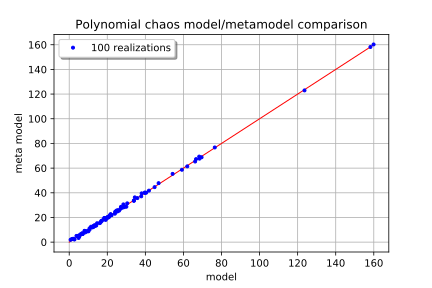

In [42]:
#####################################################
# GRAPH 2 : points cloud between model and meta model
#####################################################
ot.RandomGenerator.SetSeed(0)

# Generate a Sample of the input random vector
sizeX = 100
Xsample = Xdist.getSample(sizeX)

# Evaluate the model on the sample
modelSample = myModel(Xsample)

# Evaluate the meta model on the sample
metaModelSample = metaModel(Xsample)

# Create the sample of points (Y, Y_tilde)
sampleMixed = modelSample
sampleMixed.stack(metaModelSample)


# Put it within a graph structure
graphCloud = ot.Graph(
    "Polynomial chaos model/metamodel comparison", "model", "meta model", True, "topleft")
line = ot.SymbolicFunction(['x'], ['x']).draw(0.0, modelSample.getMax()[0]).getDrawable(0)
line.setColor('red')
graphCloud.add(line)

# Create a fine title
legend = str(sizeX) + " realizations"

# Create the cloud
comparisonCloud = ot.Cloud(sampleMixed, "blue", "bullet", legend)
comparisonCloud.setLineWidth(1)
graphCloud.add(comparisonCloud)
graphCloud